## Wikidpedia page views for the cancer treatmeant drug, Tarceva.
### by Daniel for the Meetup group, Scientists New to Data Science

This notebook takes a look at Wikipedia page views. Wikipedia might be thought of as a proxy for other other media channel interest. For instance, national interest on the cancer drug Tarceva. It's difficult to get a long history of content views from Twitter, Youtube, Facebook, etc...but Wikipedia offers a full 7 seven years of basic usage stats. In addition, the contributor's stats on edits is available. That also might yield some interesting results. 

#### For now, let's restrict ourselves to page views.

In [94]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')

    def loop_over_full_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
           
            try:
                response = urllib2.urlopen(url)
                out = response.read()
            except urllib2.HTTPError:
                print "HTTP Error, trying again."
                sleep(2)
                
                try:
                    response = urllib2.urlopen(url) #TODO: make this recursive with a counter
                    out = response.read()
                except urllib2.HTTPError:
                    continue
            
            except Exception, err:
                print err
                raise Exception    
            out = json.loads(out)
            df = pd.DataFrame(out) #, columns=['date', 'daily_views'])
            
            DF = DF.append(df)
            
        return DF
    
    def plot_time_series(self, days_df):
        '''Plot time series average per month and print labels '''
        grp = days_df.groupby('month')
        y = grp.sum()['daily_views']
        
        plt.plot(y)
        plt.xlim(0, y.shape[0])
        
        interval = 2
        labels = days_df.month.unique()
        labels = labels[0::interval]
        
        n = np.arange(len(y))[0::interval]
        plt.xticks(n, labels, rotation='vertical')      
                    
    def fft(self, data):
        '''Plot FFT using Welch's method, daily resolution '''
        plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="constant")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        plt.xticks(f[0::interval], periods, rotation="vertical")
        
        plt.plot(f, y)
        plt.show()
        
        return f, y



In [112]:
wv_tar = WikiViews("Erlotinib", '1/1/2008', '10/1/2015' )
tar = wv_tar.loop_over_full_dates()

HTTP Error, trying again.


Let's take a look a the time series data averaged per month.

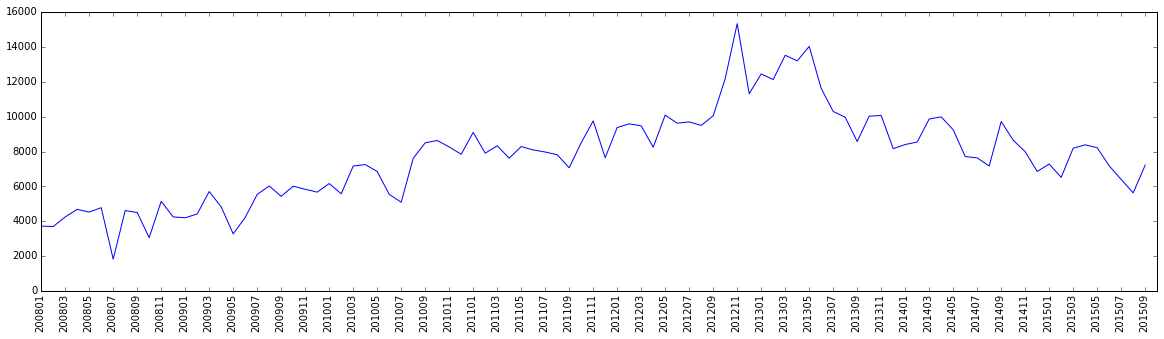

In [97]:
wv_tar.plot_time_series(tar)

## Would be good to know what caused that upward trend

In [98]:
#tar = pd.read_csv("/home/daniel/git/Python2.7/DataScience/tarceva_wiki_views.csv")
tar[tar.daily_views > tar.daily_views.mean() + 3 * tar.daily_views.std()]

,date,daily_views
489,2009-05-15,15422
1107,2011-01-14,19654
1150,2011-02-26,18821
1438,2011-12-04,24441
1537,2012-03-10,29581
2275,2014-03-04,15721
2276,2014-03-05,40858
2345,2014-05-12,74784
2346,2014-05-13,63076
2502,2014-10-14,15882


We would want to talk to a domain expert about that. Of course we an do some google searches of our own and try to find covariates.  

Might as well do some more Wikipedia pulls, because it will be hard to find source to cross reference in the news that covers a span of time. Let's try "cancer", then maybe "lung cancer" and "iressa" which was the older drug for the same purpose.

In [106]:
wv_egfr = WikiViews("Epidermal_growth_factor_receptor", '1/1/2008', '10/1/2015'  )
egfr = wv.loop_over_full_dates()

In [103]:
wv_lung = WikiViews("Lung_cancer", '1/1/2008', '10/1/2015')
lung = wv.loop_over_full_dates()

In [ ]:
wv_iressa = WikiViews("Gefitinib", '1/1/2008', '10/1/2015' )
iressa = wv.loop_over_full_dates()

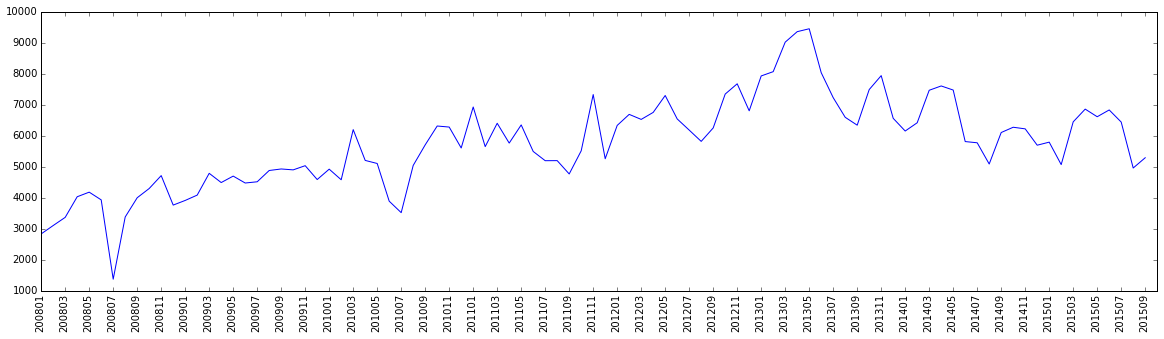

In [105]:
wv_egft.plot_time_series(egfr)
wv_tar.plot_time_series(tar)
wv_lung.plot_time_series(lung)
wv_iressa.plot_time_series(iressa)

## Correlation

Looks like the only correlation here is with Iressa which is not really helpful because we know the relationship between the two. 

In [ ]:
np.corr

## GLM

## Moving on with numerical analysis

Looks to me like there's a linear increase over time. That could be due to increased public use of Wikipedia. 
Let's detrend for partice regardless.

In [111]:
tar_copy = tar.copy()
tar_copy.head()

,date,daily_views
0,2008-01-01,3413
1,2008-01-02,5395
2,2008-01-03,5940
3,2008-01-04,5833
4,2008-01-05,4611


In [113]:
views = tar['daily_views'].squeeze()
views = scipy.signal.detrend(views, type='linear')
views -= views.min() # undo the centering
views = np.int16(np.round(views, decimals=0))
tar_copy['daily_views'] = views
wv.plot_time_series(tar_copy)

ValueError: Length of values does not match length of index

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

In [114]:
freq, amp = wv_tar.fft(tar.daily_views)

NameError: name 'wv_tar' is not defined

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. The next step would be to look for covarites to explain the time series and the periodicity. 

### Let's do some signal processing, in particular, Filtering
With straight numeric data from sensors ( typically voltages ), it's a lot more straight forward not to process the signals. There's samplerates, signal to noise ratios, published bandwidths....with social media NONE OF THAT EXISTS ! We either get our own parameters from more data or make heuristic guesses.

In [ ]:
import scipy.signal as sig
data = df.daily_views

In [ ]:
window = np.hanning(30)
plt.figure(figsize=(7,7))
plt.plot(window)

In [ ]:
data_filt_30 = sig.fftconvolve(window, data)
plt.plot(data_filt_30[0:1000])

## Before the Filter

In [ ]:
plt.figure()
plt.plot(data[0:1000])

In [ ]:
freq, y = wv.fft(data_filt_30)

####Although the peak looks bigger, there is no straight forward way to scale the y axis so we need to 
####not be too impressed with that. Really, the same two peaks are present as in the original FFT. This plot is simply cleaner. This might seem dumb, but if we where writing a peak-detector, then we'd want a simpler data set.
####Let's find peaks.

In [ ]:
import SignalProcessTools
sigtools = SignalProcessTools.SignalProcessTools()

### The Savitzky-Golay filer was taken from here: http://wiki.scipy.org/Cookbook/SavitzkyGolay

In [ ]:
def peak_detection(data):
    der1 = sigtools.savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = sigtools.savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

In [ ]:
peaks = peak_detection(data_filt_30)

In [ ]:
plt.plot(data_filt_30)
plt.vlines(peaks, 0, data_filt_30.max())

In [ ]:
peaks = peak_detection(y)
plt.figure()
plt.plot(freq, y)
plt.vlines(freq[peaks], 0, y.max(), 'r')

### There's still some ripple out to the right. We'll still need to use logic.



In [ ]:
y_peaks = y[peaks]
freq_peaks = freq[peaks]

peak_ref = np.max(y_peaks)
keep_peaks = np.where(y_peaks >= 0.1 * peak_ref)[0]

In [ ]:
plt.plot(freq, y)
plt.vlines(freq_peaks[keep_peaks], 0, y_peaks.max(), 'r')

# Generalizations about Wikipedia 

If we want to make some generalizations about Wikipedia viewership trends it would be safer to make these statements about the topics we've actually looked at. If we grab several random pages and they don't have significant depenence, then we can get a look at general trends. 

Since we have 3 cancer topics let's start simple and average those views. 

FFT and averaging are a linear operations, so it won't matter the order. Let's z-transform (center and normalize via std) then average and finally FFT the result.

In [ ]:
sum_ = np.mean(tar, cancer, lung, iressa)
